In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
def find_method_descriptor(image):
    
    descriptor = cv2.ORB_create()
    keypoints, features = descriptor.detectAndCompute(image, None)
    return keypoints, features

In [3]:
def plotSideBySide(query_image, train_image, savefig_name, xlabel_a, xlabel_b):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
    ax1.imshow(query_image)
    ax1.set_xlabel(xlabel_a, fontsize=14)

    ax2.imshow(train_image)
    ax2.set_xlabel(xlabel_b, fontsize=14)

    # Statement to be printed below the images
    plt.savefig(savefig_name+".png", bbox_inches="tight")
    plt.show()

In [4]:
def matchKeyPointsFLANN(featuresA, featuresB, ratio):
    # Define the FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # or pass empty dictionary {}

    # Create the FLANN matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Perform k-nearest neighbors matching
    rawMatches = flann.knnMatch(featuresA, featuresB, k=2)
    
    # Apply Lowe's ratio test
    matches = []
    for m, n in rawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    
    return matches


In [5]:
def getHomography(kpsA, kpsB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [6]:
def warpImage(image, H, dims):
    """
    Warp the given image using the homography matrix.
    
    Args:
        image: The image to be warped.
        H: The homography matrix.
        dims: The dimensions of the output image (typically the size of the second image).
        
    Returns:
        The warped image.
    """
    warped = cv2.warpPerspective(image, H, dims)
    return warped

In [7]:
def computeReprojectionError(kpsA, kpsB, H):
    """
    Compute the reprojection error between matched keypoints.
    
    Args:
        kpsA: Keypoints from image A.
        kpsB: Keypoints from image B.
        H: The homography matrix.
        
    Returns:
        The reprojection error.
    """
    # Convert keypoints to homogeneous coordinates (add a column of 1s for matrix multiplication)
    ptsA = np.float32([kp.pt for kp in kpsA])
    ptsB = np.float32([kp.pt for kp in kpsB])
    
    # Transform points in image A to the coordinate system of image B using homography H
    ptsA_transformed = cv2.perspectiveTransform(np.expand_dims(ptsA, axis=0), H)
    
    # Calculate Euclidean distance between actual keypoints in B and transformed points
    error = np.linalg.norm(ptsA_transformed[0] - ptsB, axis=1)
    
    # Average reprojection error
    reprojection_error = np.mean(error)
    return reprojection_error


# ORB Detector

/tmp/ipykernel_11493/2361411557.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_image = imageio.imread("./Cube/3.png")
/tmp/ipykernel_11493/2361411557.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  query_image = imageio.imread("./Cube/1.png")


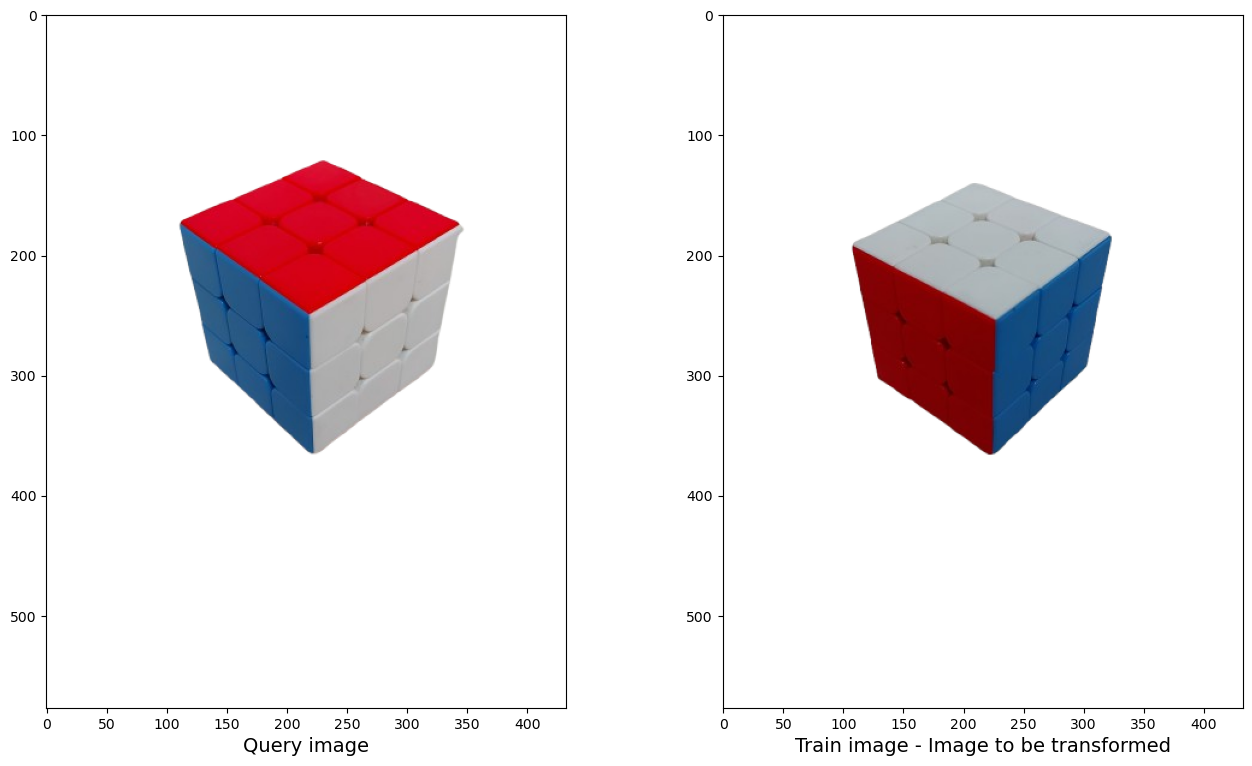

In [8]:
train_image = imageio.imread("./Cube/3.png")
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)
query_image = imageio.imread("./Cube/1.png")
query_image_gray = cv2.cvtColor(query_image,cv2.COLOR_RGB2GRAY)

plotSideBySide(query_image, train_image, "Images", "Query image", "Train image - Image to be transformed")

In [9]:
keypointsA, featuresA = find_method_descriptor(train_image_gray)
keypointsB, featuresB = find_method_descriptor(query_image_gray)

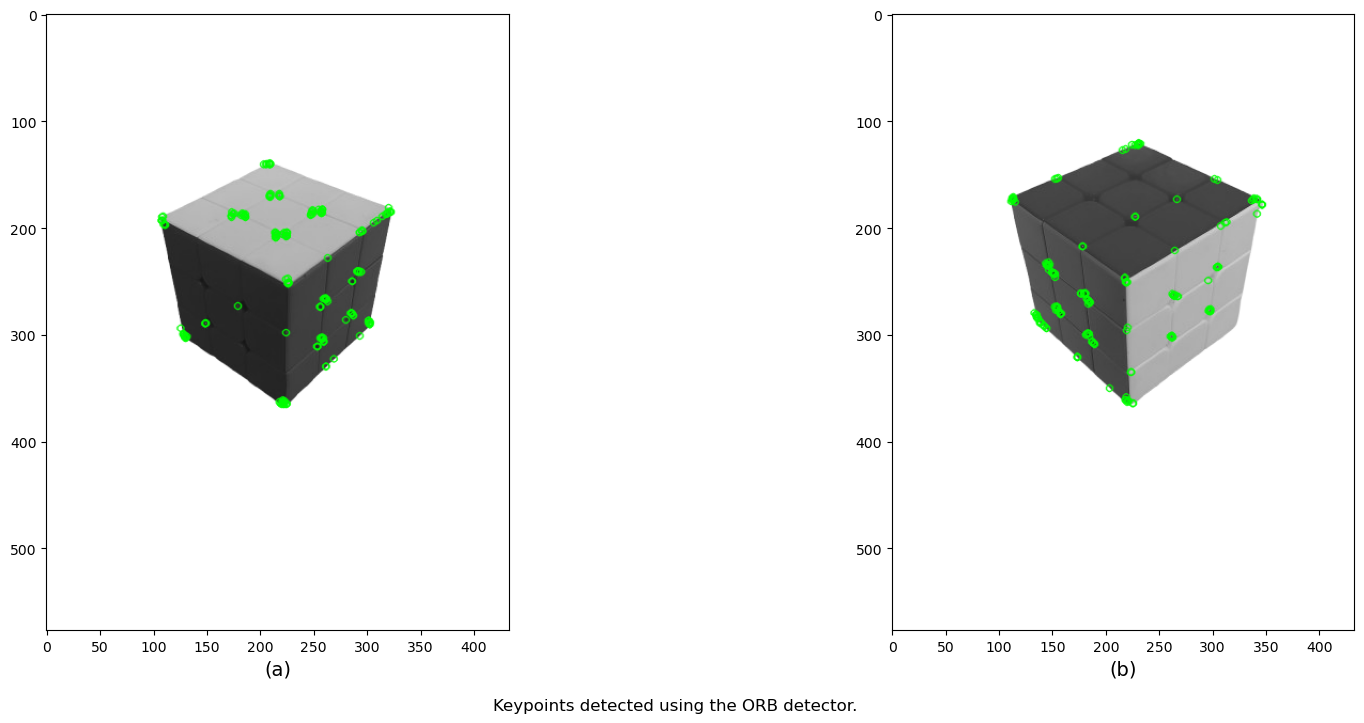

In [10]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(train_image_gray,keypointsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_image_gray,keypointsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)
statement = f'Keypoints detected using the ORB detector.'

# Print the statement below the images
fig.text(0.5, 0.01, statement, ha='center', fontsize=12)
plt.savefig("Keypoints.png", bbox_inches="tight")
plt.show()

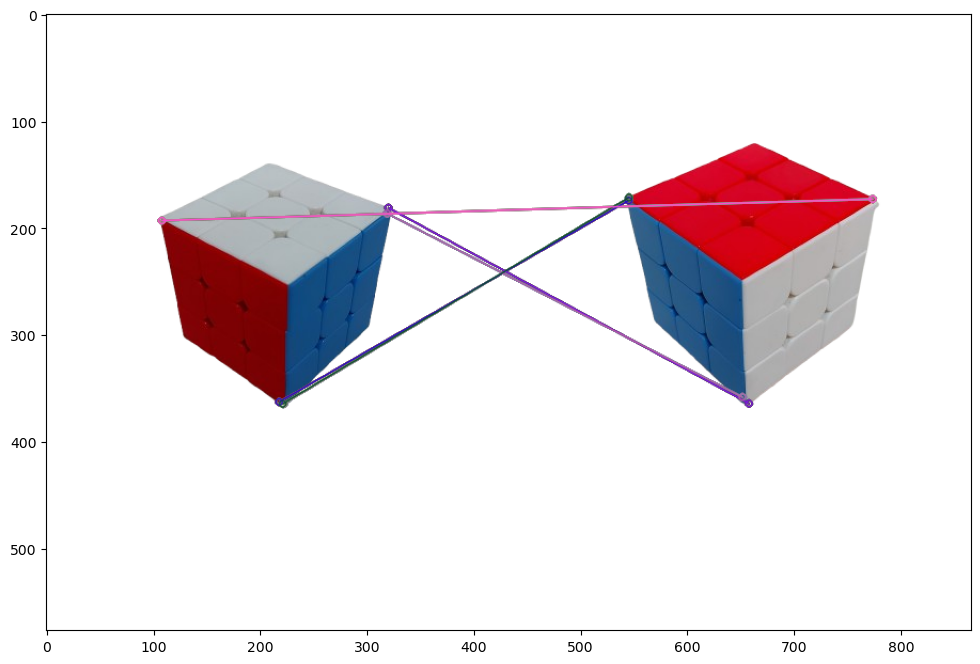

In [11]:
fig = plt.figure(figsize=(20, 8))

featuresA = np.float32(featuresA)
featuresB = np.float32(featuresB)

matches = matchKeyPointsFLANN(featuresA, featuresB, ratio=0.75)
img3 = cv2.drawMatches(train_image, keypointsA, query_image, keypointsB, np.random.choice(matches, 100), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.savefig("Matching_ORB.png", bbox_inches="tight")
plt.show()

In [12]:
M = getHomography(keypointsA, keypointsB, matches, reprojThresh=5)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[-1.03228609e+00 -1.01399983e+00  8.12679703e+02]
 [ 1.06118562e+00 -2.93794400e-01  1.98687193e+02]
 [-5.65835641e-04  2.82915807e-03  1.00000000e+00]]


In [13]:
ptsA = [keypointsA[m.queryIdx] for m in matches]
ptsB = [keypointsB[m.trainIdx] for m in matches]

# Warp image A into image B's space
warped_image = warpImage(train_image, H, (query_image.shape[1], query_image.shape[0]))

# Compute the reprojection error
error = computeReprojectionError(ptsA, ptsB, H)
print("Reprojection error:", error)

Reprojection error: 1.1292008


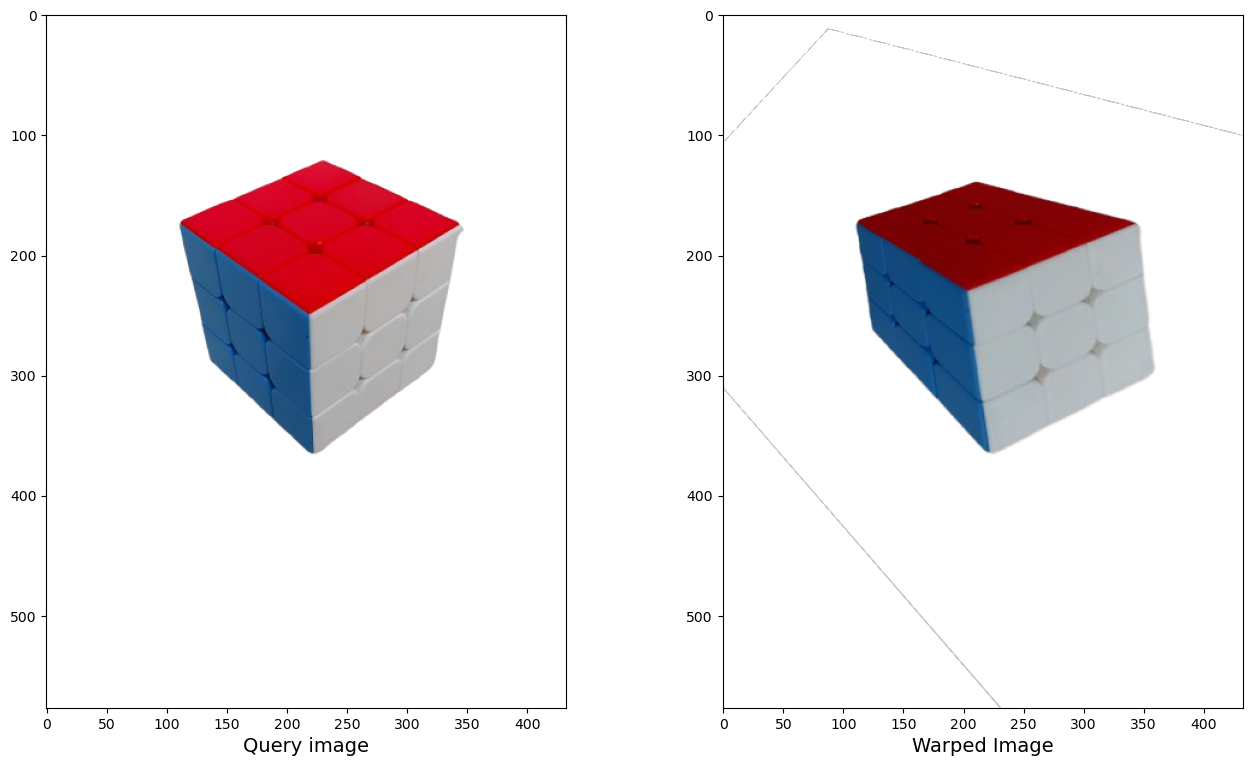

In [14]:
plotSideBySide(query_image, warped_image, "Final", "Query image", "Warped Image")